# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Описание данных
###### Признаки
 - RowNumber — индекс строки в данных
 - CustomerId — уникальный идентификатор клиента
 - Surname — фамилия
 - CreditScore — кредитный рейтинг
 - Geography — страна проживания
 - Gender — пол
 - Age — возраст
 - Tenure — количество недвижимости у клиента
 - Balance — баланс на счёте
 - NumOfProducts — количество продуктов банка, используемых клиентом
 - HasCrCard — наличие кредитной карты
 - IsActiveMember — активность клиента
 - EstimatedSalary — предполагаемая зарплата

###### Целевой признак
 - Exited — факт ухода клиента

# 1. Подготовка данных

### Изучение данных

In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [37]:
data = pd.read_csv('Churn.csv')
display(data.head())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
print(data.info())
print(data.dtypes)
print(data['Geography'].value_counts())
print(data[data['Balance'] > 0]['Balance'].count())
print(data['Exited'].value_counts(normalize = True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None
RowNumber            int64
CustomerId           int64
Surname             object
CreditSc

#### Вывод
1) Для построения моделей и решения поставленных задач, нужно избавиться от таких признаков как: RowNumber, CustomerId, Surname, т.к. они не являются информативными для построения модели.

2) В графе Tenure есть отсутсвующие значения(9 штук), необходимо выяснить можно ли их заполнить, если да, то каким образом. Также необходимо преобразовать тип данных из float в int.

3) В данных присутствует дисбаланс классов, т.к. всего 20% клиентов перестали пользоваться услугами банка.

4) Необходимо воспользоваться прямым кодированием для подготовки признаков: Geography, Gender.

5) Необходимо масштабировать количественные признаки: CreditScore, Age, Tenure, Balance, EstimatedSalary 

### Заполнение пропусков и изменение типа данных

1.0     0.104719
2.0     0.104499
8.0     0.102629
3.0     0.102079
5.0     0.101969
7.0     0.101749
4.0     0.097349
9.0     0.097019
6.0     0.096909
10.0    0.049060
0.0     0.042020
Name: Tenure, dtype: float64
5.0


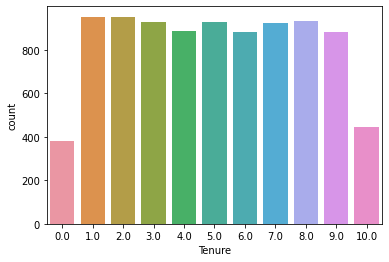

In [4]:
ax = sns.scatterplot(x="EstimatedSalary", y="Tenure",sizes=(10, 200),
                     data=data)
ax = sns.countplot(x='Tenure',data=data)
print(data['Tenure'].value_counts(normalize = True))
print(data["Tenure"].median())

In [5]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())
data['Tenure'] = data['Tenure'].astype('int')
print(data['Tenure'].describe())
print(data['Tenure'].dtypes)

count    10000.00000
mean         4.99790
std          2.76001
min          0.00000
25%          3.00000
50%          5.00000
75%          7.00000
max         10.00000
Name: Tenure, dtype: float64
int64


#### Вывод
Как видно из графика Tenure распределенно равномерно от 1 до 9, а учитывая, что пропущеных значений всего 9, то заполнение пропущенных значений медианным значением не должно внести значимые неточности в построение моделей.
Также тип данных был преобразован из float в int.

### Удаление лишних данных

In [6]:
data.drop(data[['RowNumber', 'CustomerId', 'Surname']],axis = 1, inplace = True)
display(data.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


###  Подготовка признаков и разбиение на выборки

**Прямое кодирование OHE**

Воспользуемся методом прямого кодирования для перевода категориальных признаков в числовые значения. Прямое кодирование подойдет для данной задачи, т.к. полученное кол-во новых столбцов всего 3. 

In [7]:
data = pd.get_dummies(data, drop_first=True)
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


#### Вывод
Признаки Geography и Gender были закодированы при помощи OHE, излишние признаки не учитываются из-за аргумента drop_first = True

### Разбиение на выборки

Разобьем исходную выборку на 3 части: обучающая, валидационная и тестовая в пропорции 3:1:1. Выделим признаки и целевой признак.

In [18]:
data_train_and_valid, data_test = train_test_split(data, test_size=0.2, random_state=12345)
data_train, data_valid = train_test_split(data_train_and_valid, test_size = 0.25)

features_train = data_train.drop(['Exited'], axis=1)
target_train = data_train['Exited']

features_valid = data_valid.drop(['Exited'], axis=1)
target_valid = data_valid['Exited']

features_test = data_test.drop(['Exited'], axis=1)
target_test = data_test['Exited']

### Масштабирование признаков

Произведем масштабирование количественных признаков: **'CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary'**

In [19]:
scaler = StandardScaler()
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

##  Исследование задачи

Подготовим функцию, которая будет использоваться для подсчета и вывода метрик моделей.

In [20]:
def metrics_result(predictions,target,probabilities_one):
    print('accuracy: {:.3f}'.format(accuracy_score(predictions, target)))
    print('recall: {:.3f}'.format(recall_score(predictions, target)))
    print('precision: {:.3f}'.format(precision_score(predictions, target)))
    print('f1: {:.3f}'.format(f1_score(predictions, target)))
    print('auc_roc_: {:.3f}'.format(roc_auc_score(target, probabilities_one)))
    print()

### Логистическая регрессия

В качестве первой модели выберем модель на основе логистической регрессии.

In [21]:
%%time
model = LogisticRegression(random_state = 12345, solver = 'liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
metrics_result(predicted_valid, target_valid, probabilities_one_valid)

accuracy: 0.809
recall: 0.607
precision: 0.200
f1: 0.300
auc_roc_: 0.762

CPU times: user 63.3 ms, sys: 62.6 ms, total: 126 ms
Wall time: 30.5 ms


Сравним точность с моделью, предсказывающей постоянный класс.

In [22]:
target_pred_constant = pd.Series(0, index = np.arange(len(features_valid)))
print('accuracy: {:.3f}'.format(accuracy_score(target_pred_constant, target_valid)))

accuracy: 0.794


#### Вывод
Модель линейной регрессии при имеющимся дисбалансе классов, не подходит для решения поставленной задачи, т.к. f1-мера < 0.59, а также accuracy почти такая же как и у модели, которая предсказывает постоянный класс. Auc_roc = 0.762, что больше чем 0.5 - для случайного классфикатора, но далеко от оптимального.

###  Случайный лес

Теперь обучим модель случайного леса, будем использовать перебор гиперпараметров: кол-во деревьев и максимальную глубину дерева.

In [23]:
%%time
forrest_scores = []
best_f1 = 0
for estim in range(10,101, 10):
    for k in range(1,20):
        model = RandomForestClassifier(random_state=12345, n_estimators = estim, max_depth = k)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        cur_f1_score = f1_score(predicted_valid,target_valid)
        if best_f1 < cur_f1_score:
            best_f1 = cur_f1_score
            best_predicted_valid = predicted_valid
            best_probabilities_valid = probabilities_valid
            best_probabilities_one_valid = probabilities_one_valid
            best_parametres = {'n_estimators':estim, 'max_depth': k}
        
print('Best_parametres: {}'.format(best_parametres))
metrics_result(best_predicted_valid, target_valid, best_probabilities_one_valid)

Best_parametres: {'n_estimators': 70, 'max_depth': 18}
accuracy: 0.865
recall: 0.774
precision: 0.484
f1: 0.596
auc_roc_: 0.832

CPU times: user 1min 2s, sys: 335 ms, total: 1min 2s
Wall time: 1min 2s


#### Вывод
Модели случайного леса были построены для значений гиперпараметров: кол-во деревьев от 10 до 100 с шагом 10, глубины деревьев от 1 до 20. Лучшая из полученных моделей имеет f1-меру на валидационной выборке 0.59, но при этом точность 0.48, возможно дисбаланс классов вносит коррективы в правильность модели, необходимо это исследовать. Auc_roc - 0.832, что больше, чем для модели логистической регрессии, полученной ранее.

## Борьба с дисбалансом

Применим различные методы для борьбы с диссбалансом классов. Для начала исследуем поможет ли применение этих методов улучшить качество модели логистической регрессии. 

### Логистическая регрессия

#### Взвешивание классов

In [24]:
%%time
model = LogisticRegression(random_state = 12345, solver = 'liblinear', class_weight = 'balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
metrics_result(predicted_valid, target_valid, probabilities_one_valid)

accuracy: 0.708
recall: 0.381
precision: 0.672
f1: 0.486
auc_roc_: 0.763

CPU times: user 101 ms, sys: 72.9 ms, total: 174 ms
Wall time: 82.3 ms


##### Вывод
Взвешивание классов увеличило f1-меру, но недостаточно, при этом ухудшились полнота. Необходимо искать решения дальше. Auc_roc вырос незначительно.

####  Увеличение выборки

upsample - Функция, кот-ая увеличивает обучающую выборку и перемешивает ее, т.к. изначально в данных соотношение классов было 4:1, то кол-во объектов класса '1' в обучающей выборке было увеличенно в 4 раза, чтобы получить баланс классов.

In [26]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [27]:
%%time
model = LogisticRegression(random_state = 12345, solver = 'liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
metrics_result(predicted_valid, target_valid, probabilities_one_valid)

accuracy: 0.708
recall: 0.381
precision: 0.672
f1: 0.486
auc_roc_: 0.763

CPU times: user 110 ms, sys: 56.2 ms, total: 167 ms
Wall time: 91.6 ms


##### Вывод
f1-мера почти такая же, как и при взвешивании классов, но при этом accuracy и полнота еще меньше. Auc_roc остался прежним.

#### Уменьшение выборки

downsample - Функция, кот-ая уменьшает обучающую выборку и перемешивает ее, т.к. изначально в данных соотношение классов было 4:1, то кол-во объектов класса '0' в обучающей выборке было уменьшено в 4 раза.

In [28]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [29]:
%%time
model = LogisticRegression(random_state = 12345, solver = 'liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
metrics_result(predicted_valid, target_valid, probabilities_one_valid)

accuracy: 0.697
recall: 0.368
precision: 0.664
f1: 0.474
auc_roc_: 0.759

CPU times: user 71.1 ms, sys: 40.1 ms, total: 111 ms
Wall time: 106 ms


##### Вывод
f1-мера, такая же как и при увеличении выборки, остальные показатели изменились несильно. Такой способ тоже не подходит. Auc_roc почти не изменился.

#### Изменение порога

Будем менять порог вероятности принадлежности объекта классу.

In [30]:
%%time
best_f1 = 0
model = LogisticRegression(random_state = 12345, solver = 'liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
for threshold in np.arange(0, 0.6, 0.02):
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    predicted_valid = probabilities_one_valid > threshold
    cur_f1_score = f1_score(predicted_valid,target_valid)
    if best_f1 < cur_f1_score:
        best_f1 = cur_f1_score
        best_predicted_valid = predicted_valid
        best_probabilities_valid = probabilities_valid
        best_probabilities_one_valid = probabilities_one_valid
        best_threshold = threshold
        best_parametres = {'threshold':best_threshold}
        
print('Best_parametres: {}'.format(best_parametres))
metrics_result(best_predicted_valid, target_valid, best_probabilities_one_valid)


Best_parametres: {'threshold': 0.26}
accuracy: 0.770
recall: 0.453
precision: 0.560
f1: 0.501
auc_roc_: 0.762

CPU times: user 715 ms, sys: 833 ms, total: 1.55 s
Wall time: 1.51 s


##### Вывод
Изменение порога помогло достичь такой же уровень f1-меры, что и предыдущие случаи, но при этом выросло значения полноты и ухудшилась точность, но в любом случае логистическая регрессия показывает неудоволетворительный результат для решения поставленной задачи.

### Случайный лес

Будем использовать аналогичные меры для борьбы с дисбалансом классов для случайного леса.

#### Взвешивание классов

In [31]:
%%time
forrest_scores = []
best_f1 = 0
for estim in range(10,101, 10):
    for k in range(1,20):
        model = RandomForestClassifier(random_state=12345, n_estimators = estim, max_depth = k, class_weight = 'balanced')
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        cur_f1_score = f1_score(predicted_valid,target_valid)
        if best_f1 < cur_f1_score:
            best_f1 = cur_f1_score
            best_predicted_valid = predicted_valid
            best_probabilities_valid = probabilities_valid
            best_probabilities_one_valid = probabilities_one_valid
            best_parametres = {'n_estimators':estim, 'max_depth': k}
        
print('Best_parametres: {}'.format(best_parametres))
metrics_result(best_predicted_valid, target_valid, best_probabilities_one_valid)

Best_parametres: {'n_estimators': 100, 'max_depth': 9}
accuracy: 0.836
recall: 0.590
precision: 0.664
f1: 0.625
auc_roc_: 0.849

CPU times: user 1min 1s, sys: 299 ms, total: 1min 2s
Wall time: 1min 2s


##### Вывод
При взвешивании классов f1-мера = 0.625, значения полноты и точности также выше, чем для логистической регрессии. Значение Auc_roc также выросло по сравнению с моделью без учета взвешивания классов.

####  Увеличение выборки

In [32]:
%%time
forrest_scores = []
best_f1 = 0
for estim in range(10,91, 10):
    for k in range(1,20):
        model = RandomForestClassifier(random_state=12345, n_estimators = estim, max_depth = k,)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        cur_f1_score = f1_score(predicted_valid,target_valid)
        if best_f1 < cur_f1_score:
            best_f1 = cur_f1_score
            best_predicted_valid = predicted_valid
            best_probabilities_valid = probabilities_valid
            best_probabilities_one_valid = probabilities_one_valid
            best_parametres = {'n_estimators':estim, 'max_depth': k}
        
print('Best_parametres: {}'.format(best_parametres))
metrics_result(best_predicted_valid, target_valid, best_probabilities_one_valid)

Best_parametres: {'n_estimators': 30, 'max_depth': 12}
accuracy: 0.841
recall: 0.610
precision: 0.623
f1: 0.616
auc_roc_: 0.844

CPU times: user 1min 8s, sys: 255 ms, total: 1min 8s
Wall time: 1min 8s


##### Вывод
При увеличении выборки f1-мера = 0.616, значения полноты ухудшилось, но немного возросла точность. Значение Auc_roc немного уменьшилось.

#### Уменьшение выборки

In [33]:
%%time
forrest_scores = []
best_f1 = 0
for estim in range(10,91, 10):
    for k in range(1,20):
        model = RandomForestClassifier(random_state=12345, n_estimators = estim, max_depth = k,)
        model.fit(features_downsampled, target_downsampled )
        predicted_valid = model.predict(features_valid)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        cur_f1_score = f1_score(predicted_valid,target_valid)
        if best_f1 < cur_f1_score:
            best_f1 = cur_f1_score
            best_predicted_valid = predicted_valid
            best_probabilities_valid = probabilities_valid
            best_probabilities_one_valid = probabilities_one_valid
            best_parametres = {'n_estimators':estim, 'max_depth': k}
        
print('Best_parametres: {}'.format(best_parametres))
metrics_result(best_predicted_valid, target_valid, best_probabilities_one_valid)

Best_parametres: {'n_estimators': 20, 'max_depth': 7}
accuracy: 0.778
recall: 0.476
precision: 0.759
f1: 0.585
auc_roc_: 0.842

CPU times: user 30.4 s, sys: 136 ms, total: 30.6 s
Wall time: 30.6 s


##### Вывод
f1-мера ниже, чем при предыдущих методах, значение полноты ухудщилось, но точность возросла. Значение Auc_roc немного уменьшилось.

#### Изменение порога

In [34]:
%%time
forrest_scores = []
best_f1 = 0
for threshold in np.arange(0, 0.6, 0.02):
    for estim in range(10,91, 10):
        for k in range(1,20):
            model = RandomForestClassifier(random_state=12345, n_estimators = estim, max_depth = k)
            model.fit(features_train, target_train)
            predicted_valid = model.predict(features_valid)
            probabilities_valid = model.predict_proba(features_valid)
            probabilities_one_valid = probabilities_valid[:, 1]
            predicted_valid = probabilities_one_valid > threshold
            cur_f1_score = f1_score(predicted_valid,target_valid)
            if best_f1 < cur_f1_score:
                best_f1 = cur_f1_score
                best_predicted_valid = predicted_valid
                best_probabilities_valid = probabilities_valid
                best_probabilities_one_valid = probabilities_one_valid
                best_threshold = threshold
                best_parametres = {'n_estimators':estim, 'max_depth': k, 'threshold':best_threshold}
        
print('Best_parametres: {}'.format(best_parametres))
metrics_result(best_predicted_valid, target_valid, best_probabilities_one_valid)

Best_parametres: {'n_estimators': 90, 'max_depth': 10, 'threshold': 0.34}
accuracy: 0.861
recall: 0.689
precision: 0.589
f1: 0.635
auc_roc_: 0.844

CPU times: user 25min 40s, sys: 5.22 s, total: 25min 45s
Wall time: 25min 45s


##### Вывод
f1-мера = 0.644 наибольший результат. Значение Auc_roc немного меньше, чем при взвешивании классов, но полнота и точность выросли. Модель с данными гиперпараметрами и порогом будет использоваться для тестирования.

# 4. Тестирование модели

Для начала необходимо обучить модель на обучающем и валидационном наборах. Для этого необхоимо заново выполнить масштабирование числовых признаков.

In [35]:
features_train_and_valid = data_train_and_valid.drop(['Exited'], axis=1)
target_train_and_valid = data_train_and_valid['Exited']
scaler = StandardScaler()
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
scaler.fit(features_train_and_valid[numeric])
features_train_and_valid[numeric] = scaler.transform(features_train_and_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [36]:
%%time
threshold = 0.34


model = RandomForestClassifier(n_estimators = 90, max_depth = 10, random_state = 12345,)
model.fit(features_train_and_valid,target_train_and_valid)
predicted_valid = model.predict(features_test)
probabilities_valid = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
predicted_valid = probabilities_one_valid > threshold
metrics_result(predicted_valid, target_test,probabilities_one_valid)

accuracy: 0.859
recall: 0.702
precision: 0.590
f1: 0.641
auc_roc_: 0.871

CPU times: user 718 ms, sys: 7.97 ms, total: 726 ms
Wall time: 723 ms


##### Вывод
Таким образом после обучения выбранной модели на увеличенной выборке была получена f1-мера 0.641, что больше 0.59. Следовательно модель с необходимой точностью построена. Как и казалось значение f1-метрики ухудшились по сравнению с валидационной выборкой, что свидетельсвует о переобучении модели. Но Auc_roc получилось даже немного больше, чем на валидационной выборке.

## Общий вывод
Таким образом в ходе выполнения проекта была решена поставленная задача, модель показала f1-меру на тестовой выборке 0.641 > 0.59. Были опробованы различные методы борьбы с дисбалансом классов.
Можно предположить, что выбор модели и метрики, а вместе с ними и методов избавления от дисбаланса зависит от конкретной задачи. Например, в данной задаче на мой взгляд было бы логично, искать высокое значение f1-меры, но при этом, чтобы значение полноты тоже было большим, т.е. пожертвовать "точностью". Так как я думаю, что в рамках данной задачи важнее найти всех клиентов, которые собираются покинуть банк.